In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import datetime
import numpy as np
import random
import seaborn as sns

Specifying all the focal brands

In [2]:
focal_brands = ['Sephora',
 'ULTA Beauty',
 'Olive Garden',
 'The Cheesecake Factory',
 'Target',
 'Walmart',
 'Anthropologie',
 "Victoria's Secret"]

In [3]:
competitor_brands_dict = {
 'Sephora': ["Pet Supplies Plus", "Walgreens", "Macy's", "CVS", "Target", "Nordstrom", "Walmart", "Sally Beauty Supply"],
 'ULTA Beauty': [],
 'Olive Garden': [],
 'The Cheesecake Factory': ["Texas Roadhouse", "Yard House", "Domino's Pizza", "Taco Bell",
                           "Chipotle Mexican Grill", "Panera Bread", "Boston Market",
                           "Dave & Buster's", "McDonald's", "California Pizza Kitchen",
                           "Wendy's", "Subway", "Starbucks", "Olive Garden", "KFC",
                           "IHOP", "Red Roof Inn"],
 'Target': ["ALDI", "Dollar Tree", "Dollar General", "Best Buy", "The Home Depot", "Walgreens",
           "Lowe's", "PetSmart", "BJ's Wholesale Club", "Kohl's", "Walmart", "Marshalls", "Nordstrom",
           "GameStop", "Five Below", "JCPenney", "Macy's"],
 'Walmart': [],
 'Anthropologie': [],
 "Victoria's Secret": []
 }

Reading the social brands catalog to get visits later for each store

In [4]:
brands_visits = pd.read_csv('../data/revision_visits_revenue_2019.csv')
brands_visits['brand_standard'] = brands_visits['brand'].apply(lambda x: x.strip().lower()) # For comparison with catalog.tsv
brands_visits['date'] = brands_visits['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
brands_visits = brands_visits.rename(columns={'brand': 'brand_visitation'})
brands_visits.head()

,date,PLACEKEY,visits_by_day,spend_by_day,brand_visitation,lat,lon,brand_standard
0,2019-06-01,zzw-222@62j-sgj-q2k,5,0.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
1,2019-06-02,zzw-222@62j-sgj-q2k,1,0.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
2,2019-06-03,zzw-222@62j-sgj-q2k,6,859.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
3,2019-06-04,zzw-222@62j-sgj-q2k,6,30.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
4,2019-06-05,zzw-222@62j-sgj-q2k,8,193.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness


Reading Travel Time

In [5]:
with open('../data/travel_time.pkl', 'rb') as file:
    travel_time_dict = pickle.load(file)
    
travel_time_keys = list(travel_time_dict.keys())
from_keys = [key[0] for key in travel_time_keys]
to_keys = [key[1] for key in travel_time_keys]
time_minutes = list(travel_time_dict.values())
time_minutes = [int(time_inst.split(' ')[0]) for time_inst in time_minutes]

travel_time = pd.DataFrame({'From_PLACEKEY': from_keys, 'To_PLACEKEY': to_keys, 'Time_mins': time_minutes})
travel_time.head()

,From_PLACEKEY,To_PLACEKEY,Time_mins
0,zzw-224@62k-p96-s5z,zzw-223@62k-ns4-pn5,20
1,zzw-224@62k-p96-s5z,zzy-222@62k-pd8-975,20
2,zzw-224@62k-p96-s5z,237-222@62k-p8v-z4v,16
3,zzw-224@62k-p96-s5z,222-222@62k-p8v-2p9,12
4,zzw-224@62k-p96-s5z,229-222@62k-p76-d9z,14


Reading the statistics of the specific focal brand using the results of Part 2

In [27]:
brand = focal_brands[3]
focal_brand_path = os.path.join('../part2_r_statistics', brand)
focal_brand_path

'../part2_r_statistics/The Cheesecake Factory'

In [28]:
competitor_brands = competitor_brands_dict[brand]
competitor_brands

['Texas Roadhouse',
 'Yard House',
 "Domino's Pizza",
 'Taco Bell',
 'Chipotle Mexican Grill',
 'Panera Bread',
 'Boston Market',
 "Dave & Buster's",
 "McDonald's",
 'California Pizza Kitchen',
 "Wendy's",
 'Subway',
 'Starbucks',
 'Olive Garden',
 'KFC',
 'IHOP',
 'Red Roof Inn']

Reading all the neighboring brands results and stats for the selected focal brand

In [29]:
file_list = os.listdir(focal_brand_path)
result_file_list = [file for file in file_list if file.find('_result') != -1]

In [30]:
result_df = pd.DataFrame()

for result_file in result_file_list:
    result_file_path = os.path.join(focal_brand_path, result_file)
    tmp_res_df = pd.read_csv(result_file_path, skiprows=1, float_precision="round_trip")
    # Removing all the records for ols and m_olsExp
    if 'filename' in tmp_res_df['filename'].tolist(): #Wrong input
        continue
    result_df = pd.concat([result_df, tmp_res_df], ignore_index=True)

In [31]:
result_df = result_df[~result_df['type'].isin(['ols', 'm_olsExp'])].reset_index(drop=True)
result_df = result_df.replace('FALSE', False).replace('False', False)

Extracting only the competitor brands

In [32]:
result_df = result_df[result_df['filename'].isin(competitor_brands)]

In [33]:
sum(result_df.groupby('filename')['type'].nunique() == 1)

0

In [34]:
sum(result_df.groupby('filename')['type'].nunique() == 2)

1

In [35]:
sum(result_df.groupby('filename')['type'].nunique() == 3)

0

In [36]:
sum(result_df.groupby('filename')['type'].nunique() == 4)

15

Only getting those brands who have values for all the four models

In [37]:
count_list = result_df.groupby('filename')['type'].nunique()
valid_brands = count_list[count_list == 4].index.to_list() # having the values of all the four models
len(valid_brands)

15

In [38]:
result_df = result_df[result_df['filename'].isin(valid_brands)]
result_df

,tmp,filename,type,X_Estimate,X_Std. Error,X_t value,X_Pr(>|t|),IV_firststage_reviews_tw_Estimate,IV_firststage_reviews_tw_Std. Error,IV_firststage_reviews_tw_t value,...,HausWutest_Df,HausWutest_F,HausWutest_Pr(>F),Sargan_result_rsq,Sargan_result_adjrsq,Sargan_pvalue_rsq,Sargan_pvalue_adjrsq,num_sig_variables,Y_r.squared,Y_adj.r.squared
77,tmp,Chipotle Mexican Grill,fe_reviews_reviews,0.388320,0.198401,1.957252,5.054791e-02,0.000503792913365113,4.35849891295188e-05,11.5588628889644,...,-1,1.63210870033875,0.201657301124001,3.22282169777032,-385.69440350793,0.199605801701752,1,3,0.044866,-0.201034
78,tmp,Chipotle Mexican Grill,fe_reviews_visits,0.417973,0.154424,2.706667,6.892004e-03,False,False,False,...,-1,2.11954778070833,0.145689526723181,6.08875642014771e-29,-386.589595375723,1,1,1,0.044456,-0.201549
79,tmp,Chipotle Mexican Grill,fe_exp_reviews_reviews,4.060301,2.007769,2.022295,4.336591e-02,0.00438693420931123,0.000325089666526959,13.4945360034919,...,-1,3.14350807509325,0.0764818371045371,6.98879172561883,-380.962800139607,0.0303670887837255,1,2,0.030435,-0.219180
80,tmp,Chipotle Mexican Grill,fe_exp_reviews_visits,3.949250,1.505915,2.622492,8.838750e-03,False,False,False,...,-1,3.68931175721974,0.0549975718262967,1.39567534874148e-31,-386.589595375723,1,1,1,0.030571,-0.219008
129,tmp,Subway,fe_reviews_reviews,0.648308,0.767847,0.844319,3.986586e-01,0.00173587786789707,0.000359641619989816,4.82668793435595,...,-1,2.6971910506021,0.100786344851862,1.94716214980457,-387.297155247681,0.377727941149769,1,1,0.019625,-0.235842
130,tmp,Subway,fe_reviews_visits,0.016359,2.137815,0.007652,9.938959e-01,False,False,False,...,-1,0.00544474333468024,0.941190931182667,1.78164166431452e-28,-386.589595375723,1,1,0,0.013370,-0.243727
131,tmp,Subway,fe_exp_reviews_reviews,5.894162,7.117530,0.828119,4.077671e-01,0.016973364845698,0.00204595720350102,8.29605077596605,...,-1,4.19452498142233,0.0407712471359288,1.4871611445337,-387.875105228663,0.475408629438902,1,1,0.012982,-0.244216
132,tmp,Subway,fe_exp_reviews_visits,3.051613,6.721934,0.453978,6.499261e-01,False,False,False,...,-1,0.613140560594471,0.433761766983303,1.57003429893614e-28,-386.589595375723,1,1,1,0.006569,-0.252300
218,tmp,KFC,fe_reviews_reviews,-0.137706,0.523479,-0.263060,7.925490e-01,-0.00367553782118099,0.00321473437664277,-1.1433410635374,...,-1,0.686071951119967,0.407667834357564,8.44184141697595,-379.137173604312,0.0146851175662835,1,0,0.014943,-0.241744
219,tmp,KFC,fe_reviews_visits,-84.017788,49.337523,-1.702919,8.884118e-02,False,False,False,...,-1,25.3502996065645,5.5094183811323e-07,1.17388278628935e-29,-386.589595375723,1,1,0,0.000622,-0.259797


Marking significant brands equal to competitor brands to have consistent code

In [39]:
significant_brands_list = competitor_brands
significant_brands_list

['Texas Roadhouse',
 'Yard House',
 "Domino's Pizza",
 'Taco Bell',
 'Chipotle Mexican Grill',
 'Panera Bread',
 'Boston Market',
 "Dave & Buster's",
 "McDonald's",
 'California Pizza Kitchen',
 "Wendy's",
 'Subway',
 'Starbucks',
 'Olive Garden',
 'KFC',
 'IHOP',
 'Red Roof Inn']

Filter out the results and stats for significant brands only

In [40]:
def get_pvalue_stars(p_value):
    if p_value <= 0.01:
        return '***'
    elif 0.01 < p_value <= 0.05:
        return '**'
    elif 0.05 < p_value <= 0.1:
        return '*'
    else:
        return ''

In [41]:
coeff_est_df = result_df[result_df['filename'].isin(significant_brands_list)]
coeff_est_df['X_pvalue_stars'] = coeff_est_df['X_Pr(>|t|)'].apply(get_pvalue_stars)
coeff_est_df

,tmp,filename,type,X_Estimate,X_Std. Error,X_t value,X_Pr(>|t|),IV_firststage_reviews_tw_Estimate,IV_firststage_reviews_tw_Std. Error,IV_firststage_reviews_tw_t value,...,HausWutest_F,HausWutest_Pr(>F),Sargan_result_rsq,Sargan_result_adjrsq,Sargan_pvalue_rsq,Sargan_pvalue_adjrsq,num_sig_variables,Y_r.squared,Y_adj.r.squared,X_pvalue_stars
77,tmp,Chipotle Mexican Grill,fe_reviews_reviews,0.388320,0.198401,1.957252,5.054791e-02,0.000503792913365113,4.35849891295188e-05,11.5588628889644,...,1.63210870033875,0.201657301124001,3.22282169777032,-385.69440350793,0.199605801701752,1,3,0.044866,-0.201034,*
78,tmp,Chipotle Mexican Grill,fe_reviews_visits,0.417973,0.154424,2.706667,6.892004e-03,False,False,False,...,2.11954778070833,0.145689526723181,6.08875642014771e-29,-386.589595375723,1,1,1,0.044456,-0.201549,***
79,tmp,Chipotle Mexican Grill,fe_exp_reviews_reviews,4.060301,2.007769,2.022295,4.336591e-02,0.00438693420931123,0.000325089666526959,13.4945360034919,...,3.14350807509325,0.0764818371045371,6.98879172561883,-380.962800139607,0.0303670887837255,1,2,0.030435,-0.219180,**
80,tmp,Chipotle Mexican Grill,fe_exp_reviews_visits,3.949250,1.505915,2.622492,8.838750e-03,False,False,False,...,3.68931175721974,0.0549975718262967,1.39567534874148e-31,-386.589595375723,1,1,1,0.030571,-0.219008,***
129,tmp,Subway,fe_reviews_reviews,0.648308,0.767847,0.844319,3.986586e-01,0.00173587786789707,0.000359641619989816,4.82668793435595,...,2.6971910506021,0.100786344851862,1.94716214980457,-387.297155247681,0.377727941149769,1,1,0.019625,-0.235842,
130,tmp,Subway,fe_reviews_visits,0.016359,2.137815,0.007652,9.938959e-01,False,False,False,...,0.00544474333468024,0.941190931182667,1.78164166431452e-28,-386.589595375723,1,1,0,0.013370,-0.243727,
131,tmp,Subway,fe_exp_reviews_reviews,5.894162,7.117530,0.828119,4.077671e-01,0.016973364845698,0.00204595720350102,8.29605077596605,...,4.19452498142233,0.0407712471359288,1.4871611445337,-387.875105228663,0.475408629438902,1,1,0.012982,-0.244216,
132,tmp,Subway,fe_exp_reviews_visits,3.051613,6.721934,0.453978,6.499261e-01,False,False,False,...,0.613140560594471,0.433761766983303,1.57003429893614e-28,-386.589595375723,1,1,1,0.006569,-0.252300,
218,tmp,KFC,fe_reviews_reviews,-0.137706,0.523479,-0.263060,7.925490e-01,-0.00367553782118099,0.00321473437664277,-1.1433410635374,...,0.686071951119967,0.407667834357564,8.44184141697595,-379.137173604312,0.0146851175662835,1,0,0.014943,-0.241744,
219,tmp,KFC,fe_reviews_visits,-84.017788,49.337523,-1.702919,8.884118e-02,False,False,False,...,25.3502996065645,5.5094183811323e-07,1.17388278628935e-29,-386.589595375723,1,1,0,0.000622,-0.259797,*


### Making the Figure D1 and D2 for competitors

1. Plot their X_Estimate for each of the four models
2. Put stars at the neighboring brands as per the p-value for each model \
-> *** means p_value <= 0.01 \
-> ** means 0.01 < p_value <= 0.05 \
-> * means 0.05 < p_value <= 0.1

In [42]:
dir_path = os.path.join('competitor_est_coeff_2SLS', brand)
os.makedirs(dir_path, exist_ok=True)

In [43]:
lin_reviews = coeff_est_df[coeff_est_df['type'] == 'fe_reviews_reviews'].sort_values('X_Estimate', ascending=False)
lin_visits = coeff_est_df[coeff_est_df['type'] == 'fe_reviews_visits'].sort_values('X_Estimate', ascending=False)
exp_reviews = coeff_est_df[coeff_est_df['type'] == 'fe_exp_reviews_reviews'].sort_values('X_Estimate', ascending=False)
exp_visits = coeff_est_df[coeff_est_df['type'] == 'fe_exp_reviews_visits'].sort_values('X_Estimate', ascending=False)

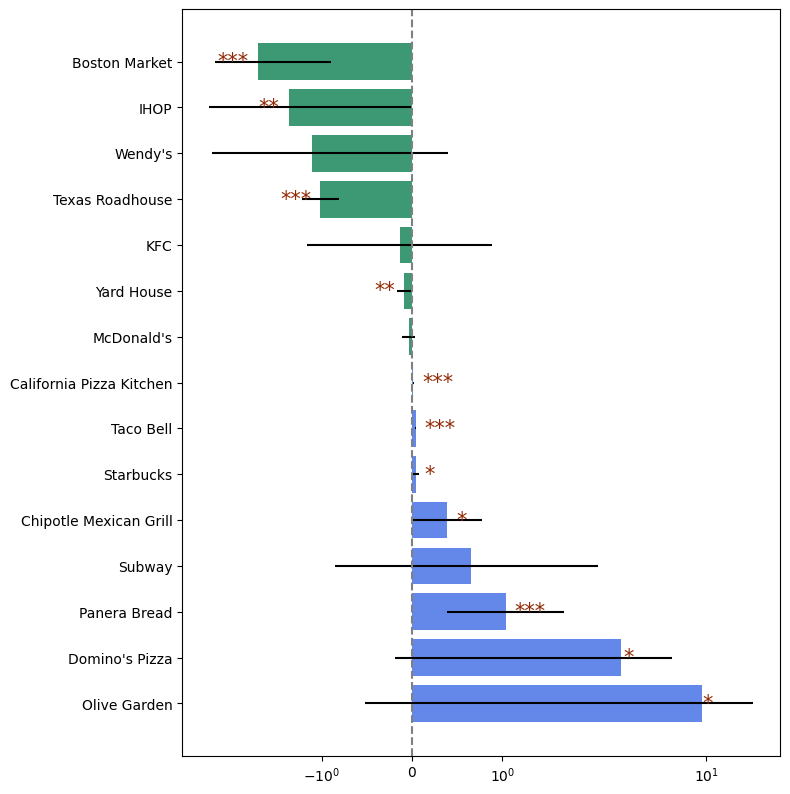

In [44]:
custom_colors = {
    'positive': '#6488ea',  # Blue for positive estimates
    'star': '#922b05',  # Red for negative estimates
    'negative': '#3d9973'       # Prettier yellow for stars
}

confidence_level = 0.95
lin_reviews['Lower Bound'] = lin_reviews['X_Estimate'] - 1.96 * lin_reviews['X_Std. Error']
lin_reviews['Upper Bound'] = lin_reviews['X_Estimate'] + 1.96 * lin_reviews['X_Std. Error']

# Create figure and axes
fig, ax = plt.subplots(figsize=(8,8))

# Add a constant offset for stars
star_offset = 0.1
    
# Set the font size for the stars
star_fontsize = 15

# Plotting estimates and confidence intervals for each business
for idx, row in lin_reviews.iterrows():
    biz_biz = row['filename']
    estimate = row['X_Estimate']
    std_error = row['X_Std. Error']
    lower_bound = row['Lower Bound']
    upper_bound = row['Upper Bound']

    # Determine the color based on the sign of the estimate
    color = custom_colors['positive'] if estimate >= 0 else custom_colors['negative']

    # Plotting the bars with different colors for positive and negative estimates
    ax.barh(biz_biz, estimate, xerr=[[estimate - lower_bound], [upper_bound - estimate]], color=color)

    # Add stars based on the number of *s in the "coefficients" column with an offset
    stars = row['X_pvalue_stars'].count('*')
    if stars > 0:
        # Set the alignment for negative estimates
        ha = 'left' if estimate >= 0 else 'right'
        ax.text(estimate + star_offset if estimate >= 0 else estimate - star_offset, biz_biz, '*' * stars, va='center', ha=ha, color=custom_colors['star'], fontsize=star_fontsize)

plt.axvline(x=0, linestyle='--', color='gray')  # Plotting a dashed line for the estimate

plt.tight_layout()

# Add labels and title
ax.set_xscale('symlog')
ax.set_xmargin(0.05)
plt.savefig(os.path.join(dir_path, 'reviews.png'))
# Show the plot
plt.show()


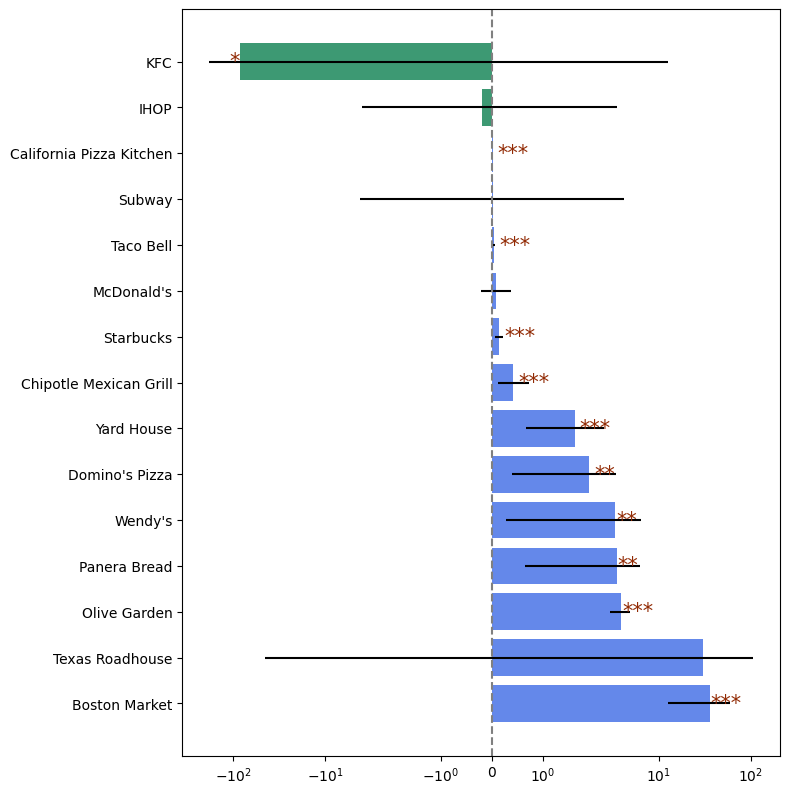

In [45]:
custom_colors = {
    'positive': '#6488ea',  # Blue for positive estimates
    'star': '#922b05',  # Red for negative estimates
    'negative': '#3d9973'       # Prettier yellow for stars
}

confidence_level = 0.95
lin_visits['Lower Bound'] = lin_visits['X_Estimate'] - 1.96 * lin_visits['X_Std. Error']
lin_visits['Upper Bound'] = lin_visits['X_Estimate'] + 1.96 * lin_visits['X_Std. Error']

# Create figure and axes
fig, ax = plt.subplots(figsize=(8,8))

# Add a constant offset for stars
star_offset = 0.1
    
# Set the font size for the stars
star_fontsize = 15

# Plotting estimates and confidence intervals for each business
for idx, row in lin_visits.iterrows():
    biz_biz = row['filename']
    estimate = row['X_Estimate']
    std_error = row['X_Std. Error']
    lower_bound = row['Lower Bound']
    upper_bound = row['Upper Bound']

    # Determine the color based on the sign of the estimate
    color = custom_colors['positive'] if estimate >= 0 else custom_colors['negative']

    # Plotting the bars with different colors for positive and negative estimates
    ax.barh(biz_biz, estimate, xerr=[[estimate - lower_bound], [upper_bound - estimate]], color=color)

    # Add stars based on the number of *s in the "coefficients" column with an offset
    stars = row['X_pvalue_stars'].count('*')
    if stars > 0:
        # Set the alignment for negative estimates
        ha = 'left' if estimate >= 0 else 'right'
        ax.text(estimate + star_offset if estimate >= 0 else estimate - star_offset, biz_biz, '*' * stars, va='center', ha=ha, color=custom_colors['star'], fontsize=star_fontsize)

plt.axvline(x=0, linestyle='--', color='gray')  # Plotting a dashed line for the estimate

plt.tight_layout()

# Add labels and title
ax.set_xscale('symlog')
ax.set_xmargin(0.05)
plt.savefig(os.path.join(dir_path, 'visits.png'))
# Show the plot
plt.show()


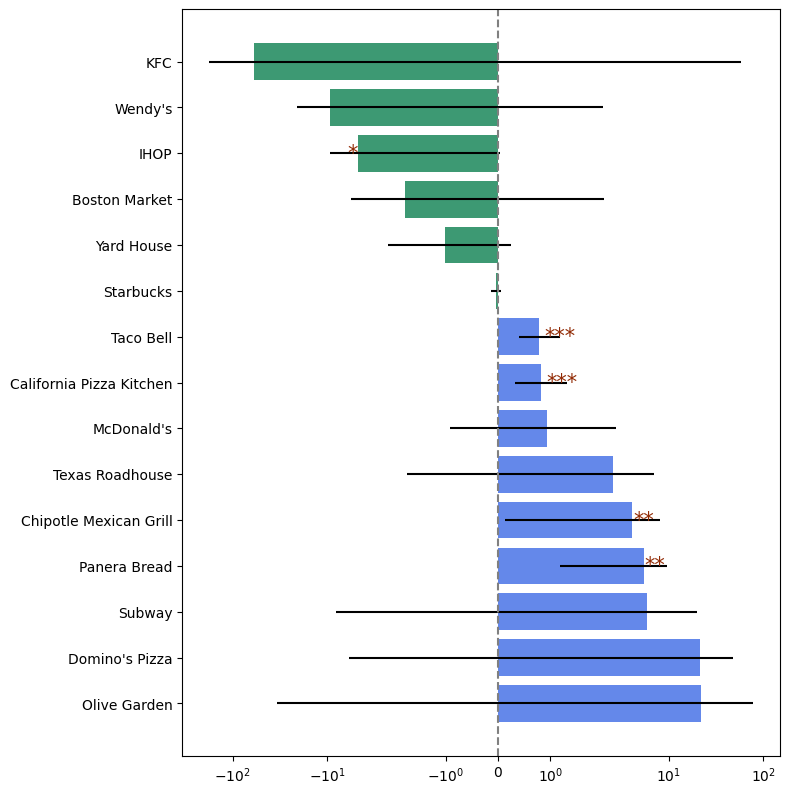

In [46]:
custom_colors = {
    'positive': '#6488ea',  # Blue for positive estimates
    'star': '#922b05',  # Red for negative estimates
    'negative': '#3d9973'       # Prettier yellow for stars
}

confidence_level = 0.95
exp_reviews['Lower Bound'] = exp_reviews['X_Estimate'] - 1.96 * exp_reviews['X_Std. Error']
exp_reviews['Upper Bound'] = exp_reviews['X_Estimate'] + 1.96 * exp_reviews['X_Std. Error']

# Create figure and axes
fig, ax = plt.subplots(figsize=(8,8))

# Add a constant offset for stars
star_offset = 0.1
    
# Set the font size for the stars
star_fontsize = 15

# Plotting estimates and confidence intervals for each business
for idx, row in exp_reviews.iterrows():
    biz_biz = row['filename']
    estimate = row['X_Estimate']
    std_error = row['X_Std. Error']
    lower_bound = row['Lower Bound']
    upper_bound = row['Upper Bound']

    # Determine the color based on the sign of the estimate
    color = custom_colors['positive'] if estimate >= 0 else custom_colors['negative']

    # Plotting the bars with different colors for positive and negative estimates
    ax.barh(biz_biz, estimate, xerr=[[estimate - lower_bound], [upper_bound - estimate]], color=color)

    # Add stars based on the number of *s in the "coefficients" column with an offset
    stars = row['X_pvalue_stars'].count('*')
    if stars > 0:
        # Set the alignment for negative estimates
        ha = 'left' if estimate >= 0 else 'right'
        ax.text(estimate + star_offset if estimate >= 0 else estimate - star_offset, biz_biz, '*' * stars, va='center', ha=ha, color=custom_colors['star'], fontsize=star_fontsize)

plt.axvline(x=0, linestyle='--', color='gray')  # Plotting a dashed line for the estimate

plt.tight_layout()

# Add labels and title
ax.set_xscale('symlog')
ax.set_xmargin(0.05)

plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))
# Show the plot
plt.show()


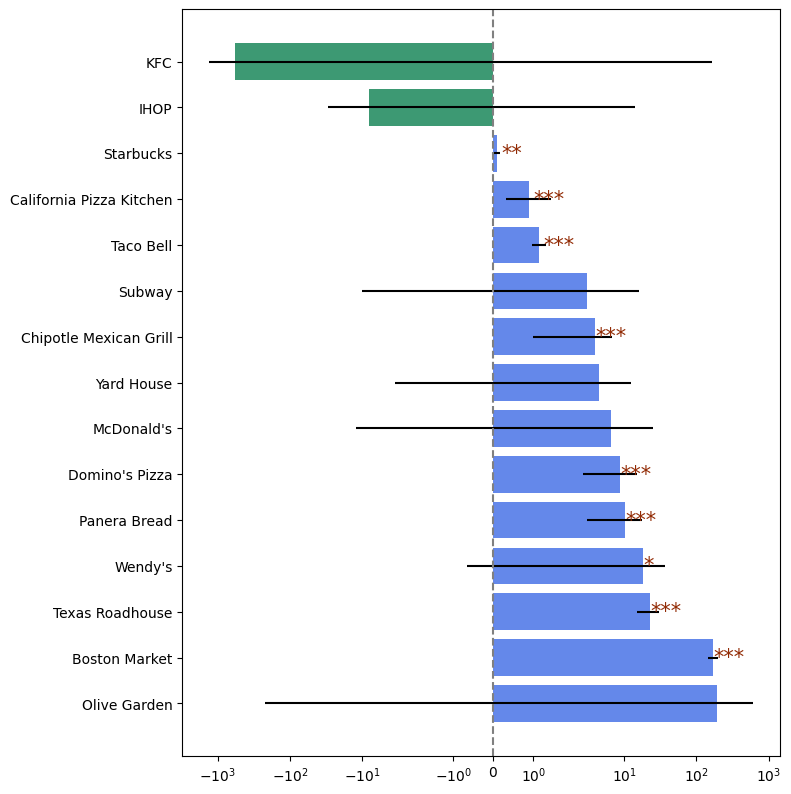

In [47]:
custom_colors = {
    'positive': '#6488ea',  # Blue for positive estimates
    'star': '#922b05',  # Red for negative estimates
    'negative': '#3d9973'       # Prettier yellow for stars
}

confidence_level = 0.95
exp_visits['Lower Bound'] = exp_visits['X_Estimate'] - 1.96 * exp_visits['X_Std. Error']
exp_visits['Upper Bound'] = exp_visits['X_Estimate'] + 1.96 * exp_visits['X_Std. Error']

# Create figure and axes
fig, ax = plt.subplots(figsize=(8,8))

# Add a constant offset for stars
star_offset = 0.1
    
# Set the font size for the stars
star_fontsize = 15

# Plotting estimates and confidence intervals for each business
for idx, row in exp_visits.iterrows():
    biz_biz = row['filename']
    estimate = row['X_Estimate']
    std_error = row['X_Std. Error']
    lower_bound = row['Lower Bound']
    upper_bound = row['Upper Bound']

    # Determine the color based on the sign of the estimate
    color = custom_colors['positive'] if estimate >= 0 else custom_colors['negative']

    # Plotting the bars with different colors for positive and negative estimates
    ax.barh(biz_biz, estimate, xerr=[[estimate - lower_bound], [upper_bound - estimate]], color=color)

    # Add stars based on the number of *s in the "coefficients" column with an offset
    stars = row['X_pvalue_stars'].count('*')
    if stars > 0:
        # Set the alignment for negative estimates
        ha = 'left' if estimate >= 0 else 'right'
        ax.text(estimate + star_offset if estimate >= 0 else estimate - star_offset, biz_biz, '*' * stars, va='center', ha=ha, color=custom_colors['star'], fontsize=star_fontsize)

plt.axvline(x=0, linestyle='--', color='gray')  # Plotting a dashed line for the estimate

plt.tight_layout()

# Add labels and title
ax.set_xscale('symlog')
ax.set_xmargin(0.05)
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))
# Show the plot
plt.show()